In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from numpy.polynomial.polynomial import polyfit, polyval

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [3]:
from mgwr.kernels import Kernel
from spglm.iwls import _compute_betas_gwr

In [4]:
trial = np.load('../data/Trial_Design.npy')
trial_names = np.load('../data/Trial_Design_names.npy', allow_pickle=True)
trial_coords = np.load('../data/Trial_Design_coords.npy')
trial_coords_idx = np.int0(np.floor(trial_coords/3))
n = trial_coords.shape[0]

rst_sim = np.load('../data/Trial_sim.npy')

In [5]:
# trial_idx = [i for i, n in enumerate(trial_names) if not 'rep' in n]

In [6]:
trial_names

array(['size3_rep', 'size3_p01', 'size3_p05', 'size3_p10', 'size3_p50',
       'size3_p100', 'size6_rep', 'size6_p01', 'size6_p05', 'size6_p10',
       'size6_p50', 'size6_p100', 'size15_rep', 'size15_p01',
       'size15_p05', 'size15_p10', 'size15_p50', 'size15_p100',
       'size30_rep', 'size30_p01', 'size30_p05', 'size30_p10',
       'size30_p50', 'size30_p100', 'size60_rep', 'size60_p01',
       'size60_p05', 'size60_p10', 'size60_p50', 'size60_p100',
       'size3s_rep', 'size3s_p01', 'size3s_p05', 'size3s_p10',
       'size3s_p50', 'size3s_p100'], dtype=object)

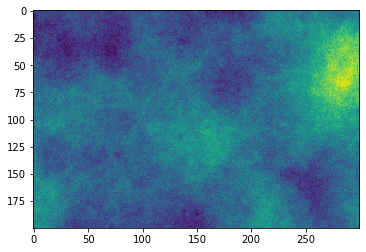

In [7]:
plt.imshow(rst_sim[0])

In [8]:
idx = np.where(trial_names == 'size15_p100')[0][0]
idx

17

In [9]:
cotton_price = 0.4
nitrogen_cost = 1.0
nitrogen_ratio = nitrogen_cost/cotton_price

In [10]:
bw = 200
b0_true = rst_sim[0]
b1_true = rst_sim[1]
na_crit = ~np.isnan(trial[idx].reshape(-1))
trial_rst = np.nan_to_num(trial[idx])
coords = trial_coords[na_crit]
cidx = trial_coords_idx[na_crit]


In [11]:
wi_all = []
for i in trange(n):
    wi = Kernel(i, coords, bw, fixed=False, function='gaussian', points = trial_coords)
    wi_all.append(wi.kernel.reshape(-1, 1))


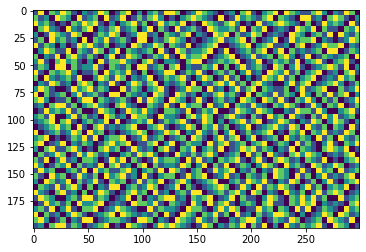

In [12]:
plt.imshow(trial_rst)


In [13]:
sq_rate = 100
sq_yield = 4500
rst_b2g = -0.02

rst_optr = sq_rate * (1 + 0.25 * b1_true) 
rst_optr = np.clip(rst_optr, 0, 200)

rst_b1 = -2 * rst_b2g * rst_optr + nitrogen_ratio
rst_b0 = sq_yield * (1 + 0.05 * b0_true)
rst_b0 = rst_b0 - (rst_b1 * rst_optr + rst_b2g * rst_optr **2) 

inp_rate = sq_rate + 12.5 * trial_rst

rst_yield_ref =  rst_b0 + rst_b1 * sq_rate + rst_b2g * sq_rate**2
rst_yield_obs =  rst_b0 + rst_b1 * inp_rate + rst_b2g * inp_rate**2
rst_yield_opt =  rst_b0 + rst_b1 * rst_optr + rst_b2g * rst_optr**2

y_obs = rst_yield_obs.reshape(-1)

rst_net_ref = rst_yield_ref * cotton_price - sq_rate * nitrogen_cost
rst_net_obs = rst_yield_obs * cotton_price - inp_rate * nitrogen_cost 
rst_net_opt = rst_yield_opt * cotton_price - rst_optr * nitrogen_cost 


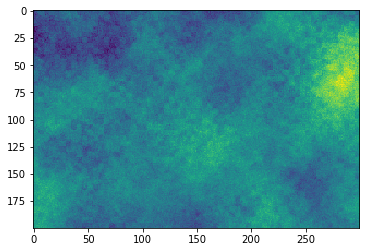

In [14]:
plt.imshow(rst_yield_obs)

(array([  103.,  1172.,  4889., 15003., 22748., 11509.,  2618.,  1335.,
          552.,    71.]),
 array([3620.40170283, 3815.53496778, 4010.66823273, 4205.80149767,
        4400.93476262, 4596.06802756, 4791.20129251, 4986.33455745,
        5181.4678224 , 5376.60108735, 5571.73435229]),
 <a list of 10 Patch objects>)

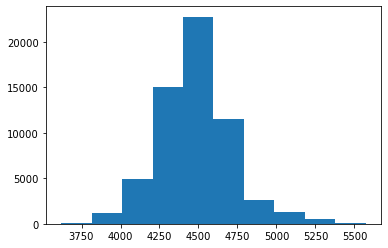

In [15]:
plt.hist(y_obs)

(array([  209.,  2153.,  6616., 11820., 15192., 13262.,  7656.,  2684.,
          389.,    19.]),
 array([ 21.86014468,  38.84378166,  55.82741864,  72.81105561,
         89.79469259, 106.77832957, 123.76196654, 140.74560352,
        157.7292405 , 174.71287747, 191.69651445]),
 <a list of 10 Patch objects>)

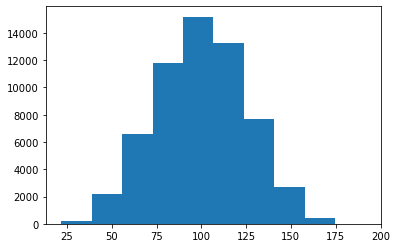

In [16]:
plt.hist(rst_optr.reshape(-1))

In [17]:
y = rst_yield_obs.reshape(-1,1)[na_crit].copy()
X = inp_rate.reshape(-1,1)[na_crit].copy()

y_std = StandardScaler().fit(y)
y = y_std.transform(y)

X_std = StandardScaler().fit(X)
X = X_std.transform(X)

X = np.concatenate([np.ones_like(X), X, X**2], -1)

In [18]:
lr = LinearRegression(fit_intercept = False)
lr.fit(X, y)
y_resd = y - lr.predict(X)

In [19]:
betasl = []
for i in trange(n):
    wi = wi_all[i]
    wcrit = wi[:,0] > 0.001
    betas, inv_xtx_xt = _compute_betas_gwr(y_resd[wcrit], X[wcrit,:2], wi[wcrit])
    betasl.append(betas)


In [20]:
X = inp_rate.reshape(-1,1)
X = X_std.transform(X)
X = np.concatenate([np.ones_like(X), X, X**2], -1)

In [21]:
npbetas = np.concatenate(betasl, -1)
beta_pred = np.concatenate([npbetas, np.zeros_like(npbetas[[0]])])
beta_pred = beta_pred + lr.coef_[0,:,None]
y_pred = (beta_pred.T * X).sum(1)
y_pred = y_std.inverse_transform(y_pred)


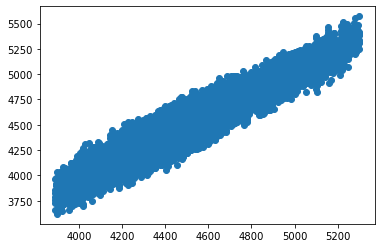

In [22]:
plt.scatter(y_pred, y_obs)

In [23]:
X_test = np.linspace(0, 200, 200)
X = X_test[None] + np.zeros_like(inp_rate.reshape(-1,1))
X = X_std.transform(X)[:,:,None]
X = np.concatenate([np.ones_like(X), X, X**2], -1)


In [24]:
y_test = (beta_pred[:,None].T * X).sum(-1)
y_cost = y_std.transform((nitrogen_ratio * X_test)[None])
y_eco = y_test - y_cost


In [25]:
best_idx = y_eco.argmax(-1)
best_x = X_test[best_idx]
rst_optr_pred = best_x.reshape(rst_optr.shape)

best_y = y_test[np.arange(len(best_idx)), best_idx]
best_y = y_std.inverse_transform(best_y)


In [26]:
np.corrcoef(best_x.reshape(-1), rst_optr.reshape(-1))

array([[1.        , 0.76280078],
       [0.76280078, 1.        ]])

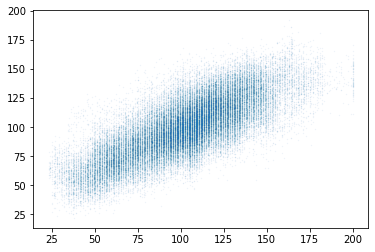

In [27]:
plt.scatter(best_x.reshape(-1), rst_optr.reshape(-1), alpha=0.1, s = 0.1)

(array([ 1305.,  4644.,  6503.,  9467., 15221., 11656.,  7681.,  2428.,
          947.,   148.]),
 array([ 23.11557789,  40.8040201 ,  58.49246231,  76.18090452,
         93.86934673, 111.55778894, 129.24623116, 146.93467337,
        164.62311558, 182.31155779, 200.        ]),
 <a list of 10 Patch objects>)

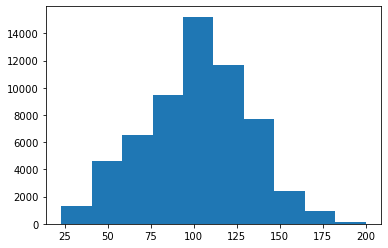

In [28]:
plt.hist(best_x.reshape(-1))

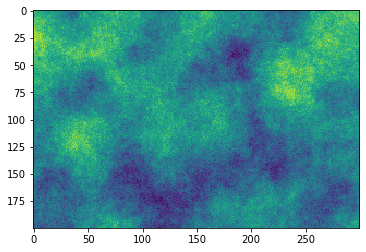

In [29]:
plt.imshow(rst_optr)

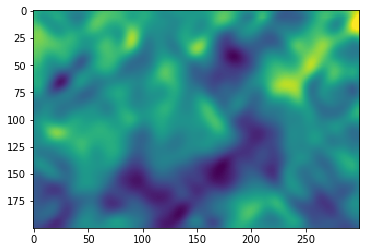

In [30]:
plt.imshow(rst_optr_pred)

In [35]:
import torch
device = torch.device('cpu')


y = rst_yield_obs.reshape(-1,1)[na_crit].copy()
X = inp_rate.reshape(-1,1)[na_crit].copy()

y_std = StandardScaler().fit(y)
y = y_std.transform(y)

X_std = StandardScaler().fit(X)
X = X_std.transform(X)

X = np.concatenate([np.ones_like(X), X, X**2], -1)


In [39]:
wi_np = np.stack(wi_all)

In [41]:
A = torch.tensor(y_resd, device=device)
B = torch.tensor(X[:,:2], device=device)
WW = torch.tensor(wi_np, device=device)

In [ ]:
betasl = []
for i in trange(n):
    wi = WW[i]
    wcrit = wi[:,0] > 0.001
    W = wi[wcrit]
    betas = torch.lstsq(A[wcrit]*W, B[wcrit]*W)[0][:2]
    betasl.append(betas)

